# Tools

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from sklearn.cluster import OPTICS
from collections import Counter

In [118]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [119]:
max_number_of_clusters = 30
min_number_of_clusters = 2

class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.NONE.value

class CLUSTER_METHOD(Enum):
    KMEANS = 1 
    OPTICS = 2 

cluster_method = CLUSTER_METHOD.OPTICS.value

# exclude_features = ["stddev_received_tx",
#                     "stddev_sent_tx",
#                     "avg_time_diff_sent_tx",
#                     "avg_time_diff_received_tx",
#                     "balance",
#                     "usd_received",
#                     "usd_sent",
#                     "avg_usd_sent",
#                     "avg_usd_received",
#                     "monthly_usd_sent",
#                     "monthly_usd_received",
#                     "monthly_outgoing_txns",
#                     "monthly_incoming_txns",
#                     "avg_wei_sent",
#                     "avg_wei_received",
#                     "monthly_wei_sent",
#                     "monthly_wei_received"                                 
#                      ]
exclude_features = []

reset_clustering_result = True

In [120]:
number_of_addresses = 100000

# format: yyyy-mm-dd
observation_period_start = "2019-01-01 00:00:00+00"
observation_period_end = "2020-01-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.RICHEST.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset_feature_tables = False

# Create feature table in bigquery

In [121]:
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

In [122]:
try:
    pm.execute_notebook(
       './bigquery/features.ipynb',
       './build/{}.build.ipynb'.format(table_id),
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset_feature_tables),
       cwd = "./bigquery"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise


Feature table does already exist.


# Load feature table from bigquery

In [123]:
filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset_feature_tables == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        
features = features.dropna()

Loading data from local cache ...
Time to retrieve data from local cache: 7 Seconds.


In [124]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 22.0 Megabytes.


# Set avg_time_diff and stddev 0 values to max

In [125]:
features["avg_time_diff_sent_tx"] = features["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_sent_tx"]))
features["avg_time_diff_received_tx"] = features["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_received_tx"]))

In [126]:
features["stddev_received_tx"] = features["stddev_received_tx"].replace(to_replace=0.0, value=max(features["stddev_received_tx"]))
features["stddev_sent_tx"] = features["stddev_sent_tx"].replace(to_replace=0.0, value=max(features["stddev_sent_tx"]))

# Exclude features

In [127]:
if len(exclude_features) > 0:
    features = features.drop(columns=exclude_features) 

# Standardise feature values, so that all feature values have the same mean and stddev

In [128]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Use Isolationforest to identify outliers

In [129]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination='auto')

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

Number of detected outliers: 4905


In [130]:
# Display outliers
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head()

,wei_received,wei_sent,number_of_tx_received,number_of_tx_sent,mined_blocks,active_months,number_of_contracts_created,contract_tx,diff_token_used,turnover
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,31775635570468552512270039,31728639908003043820433568,1544933,790888,0,12,0,491544,130,63504275478471596332703607
0x876eabf441b2ee5b5b0554fd502a8e0600950cfa,13659176908290657247938470,13592718846288260000000000,159599,158003,0,12,0,92829,128,27251895754578917247938470
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,9714702281975000498986560,9108196883921430939413347,5056085,445177,0,12,0,0,1,18822899165896431438399907
0x564286362092d8e7936f0549571a803b203aaced,7202796319776894981204226,7198444674807110000000000,835,711166,0,12,0,420722,125,14401240994584004981204226
0xd551234ae421e3bcba99a0da6d736074f22192ff,7114004547067957199960952,7109415628180520000000000,831,700592,0,12,0,413692,123,14223420175248477199960952


In [131]:
# # opens outliers features.index via etherscan
# n = 5 # first n features.index get opened
# i = 0
# for address, features in outliers_tmp.iterrows():
#     webbrowser.open('https://etherscan.io/address/{}'.format(address), new=2)
#     i += 1
#     if i == n:
#         break

# Use Isolationforest to remove outliers

In [132]:
if outlier_removal == OUTLIER_REMOVAL.ISOLATION_FOREST.value:
    features = features_clean
    features_std = features_std_clean

# Dimension Reduction via Principal Component Analysis

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [133]:
min_explained_variance = 0.9

In [134]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 6 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.


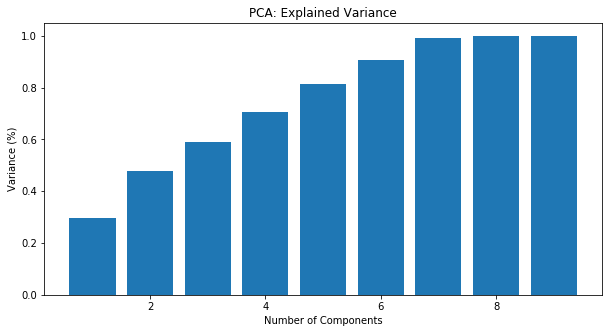

In [135]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [136]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5
0x0000000000000000000000000000000000000000,7.818003,-2.939221,-29.060909,236.263431,206.801786,-4.125766
0x000000000000000000000000000000000000001d,-0.084380,0.034007,-0.051091,-0.538739,0.584173,-0.012519
0x000000000000000000000000000000000000dead,2.872928,0.726426,0.129876,1.865987,-1.543790,0.449133
0x00000000000000000000f2d0c1ed19a8f65357a0,-0.084304,0.034078,-0.051093,-0.538742,0.584173,-0.012508
0x000000000000541e251335090ac5b47176af4f7e,0.616029,-0.664123,-0.280390,0.081978,0.020621,0.152737


# Caluclate number of clusters via Clinski Harabasz Score (only when using K-MEANS)

In [137]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [138]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [139]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    scores = []
    numberOfCluster = []
    
    # 3 clusters are not considered to be valid
    for i in range(min_number_of_clusters, max_number_of_clusters, 1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
    optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

In [140]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    plt.figure(figsize=(10,5))
    bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
    plt.xlabel(results.columns[0])
    plt.ylabel(results.columns[1]) 
    bars[results["calinski_score"].idxmax()].set_color("r")
    plt.show()
    plt.close()
    print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

In [141]:
#  optimal_number_of_clusters = 5 # tmp

# Clustering

In [ ]:
filename = "clustering_result_{}".format(table_id)
data_dir = "./data"

if filename not in os.listdir(data_dir) or reset_clustering_result == True:
    
    if cluster_method == CLUSTER_METHOD.KMEANS.value:
        cluster_model = KMeans(n_clusters=optimal_number_of_clusters)

    if cluster_method == CLUSTER_METHOD.OPTICS.value:
        cluster_model = OPTICS(max_eps=0.00000000001)
    
    print("Clustering data ...")
    start = time.time();

    cluster_model.fit(features_std_pca)
    
    features["label"] = cluster_model.labels_
    
    done = time.time();
    elapsed = round(done - start);
    print("Time to cluster data: {} Minutes.".format(round(elapsed/60)))
    
    # save clustering results in order to save time in the next run
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
else:
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))    

Clustering data ...


In [ ]:
features["label"].unique()

# Remove outliers for each cluster via variance threshold

In [143]:
features_std_pca.head()

,0,1,2,3,4,5
0x0000000000000000000000000000000000000000,7.818003,-2.939221,-29.060909,236.263431,206.801786,-4.125766
0x000000000000000000000000000000000000001d,-0.084380,0.034007,-0.051091,-0.538739,0.584173,-0.012519
0x000000000000000000000000000000000000dead,2.872928,0.726426,0.129876,1.865987,-1.543790,0.449133
0x00000000000000000000f2d0c1ed19a8f65357a0,-0.084304,0.034078,-0.051093,-0.538742,0.584173,-0.012508
0x000000000000541e251335090ac5b47176af4f7e,0.616029,-0.664123,-0.280390,0.081978,0.020621,0.152737


In [144]:
def remove_outliers(features, cluster_model, threshold):
    
    features_without_outliers = pd.DataFrame()
    labels_without_outliers = []

    for label in np.unique(cluster_model.labels_):
        centroid = np.array(features_std_pca[cluster_model.labels_ == label].mean())

        features_within_cluster = features[cluster_model.labels_ == label];
        # distance of each point in cluster to cluster's centroid
        distances = features_within_cluster - centroid;
        # convert to scalar
        distances_norm = np.linalg.norm(distances, axis=1);
        # max_distance for this cluster
        max_distance = threshold * np.linalg.norm(features_within_cluster.std())
        
        keep = distances_norm <= max_distance
        
        features_without_outliers = features_without_outliers.append(features_within_cluster[keep])
        labels_without_outliers.extend([label for i in features_within_cluster[keep].iterrows()])
        
    features_without_outliers["label"] = labels_without_outliers
    return features_without_outliers

In [145]:
if outlier_removal == OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value:
    from sklearn.metrics import calinski_harabaz_score as ch_score
    
    thresholds = np.linspace(.0001,.6, 20)
    
    features_tables_without_outliers = [remove_outliers(features_std_pca, cluster_model, t) for t in thresholds]
    
    scores= []
    res = []
    
    for f,t in zip(features_tables_without_outliers, thresholds):
        if not f.empty and len(f["label"].unique()) > 1 and len(f) > 4:
            scores.append((metrics.calinski_harabasz_score(f.drop(columns=["label"]), f["label"]), t))
            res.append(f)
            
    scores = [x for x in zip(*scores)]
    
    plt.plot(scores[1], scores[0])
    plt.title('Calinski Harabaz Scores as std threshold changes')    
    
    optimal_threshold = thresholds[np.argmax(scores)]
    features_std_pca_without_outliers = res[np.argmax(scores)]
    features = features.reindex(features_std_pca_without_outliers.index)
    features_std = features_std.reindex(features_std_pca_without_outliers.index)
    features_std_pca = features_std_pca.reindex(features_std_pca_without_outliers.index)  
    
    print("The threshold leading to the highest Calinski Harabaz Score is", optimal_threshold)

# Visualisierung: T-SNE

In [146]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# features_std_pca_out_tsne = tsne.fit_transform(features_std_pca_out)
# features_std_pca_out_tsne = pd.DataFrame(features_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# features_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [147]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# features_std_pca_out_tsne["Label"] = cluster_model.labels_
# features_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=features_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Display principal components

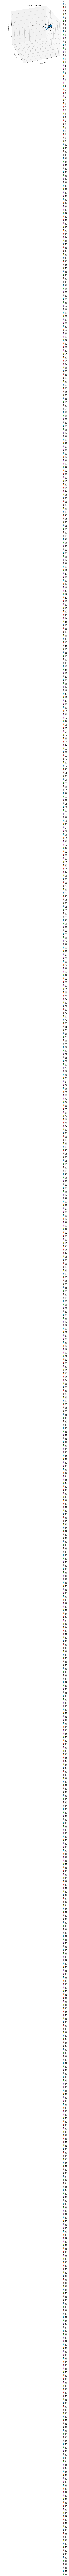

In [148]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features["label"]

labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, alpha = 1);

ax.set_title("First three PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);
ax.legend(title= "Clusters")

# Display cluster means 

In [149]:
clusters = dict() 
labels = features["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features[features.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

In [150]:
feature_means_display = feature_means.round()

if "wei_received" in feature_means_display.columns:
    feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_received"])

if "wei_sent" in feature_means_display.columns:
    feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_sent"])

    
if "balance" in feature_means_display.columns:
    feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["balance"])
    
if "avg_wei_sent" in feature_means_display.columns:
    feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
    
if "avg_wei_received" in feature_means_display.columns:
    feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
    
if "monthly_wei_sent" in feature_means_display.columns:
    feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
    
if "monthly_wei_received" in feature_means_display.columns:
    feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])
    
feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

if set(["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]).issubset(set(feature_means_display.columns)):
    cols = list(feature_means_display.columns.values) 
    cols.pop(cols.index('number_of_addresses')) 
    cols.pop(cols.index('eth_balance')) 
    cols.pop(cols.index('eth_sent')) 
    cols.pop(cols.index('eth_received')) 
    feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.T.astype("int"))
else:
    display(feature_means_display.astype("int"))

,number_of_tx_received,number_of_tx_sent,mined_blocks,active_months,number_of_contracts_created,contract_tx,diff_token_used,eth_received,eth_sent,number_of_addresses
cluster_-1,457,567,6,4,12,424,1,2894,2448,81577
cluster_0,1,0,0,1,0,0,0,16,0,12
cluster_1,1,0,0,1,0,0,0,16,0,15
cluster_2,1,0,0,1,0,0,0,16,0,9
cluster_3,1,0,0,1,0,0,0,16,0,7
cluster_4,1,0,0,1,0,0,0,16,0,9
cluster_5,1,0,0,1,0,0,0,16,0,6
cluster_6,1,0,0,1,0,0,0,16,0,8
cluster_7,1,0,0,1,0,0,0,16,0,12
cluster_8,1,0,0,1,0,0,0,16,0,7


In [151]:
# features[features["label"] == 1]

In [152]:
# fig, ax = plt.subplots(figsize= (20,10))

# scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
# features_std = scaler.fit_transform(features);
# features_std = pd.DataFrame(features_std, columns=features.columns);
# X_reduced = PCA(n_components=2).fit_transform(features_std);

# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_model.labels_)
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# pd.Series(cluster_model.labels_).unique()

In [153]:
# features_std_pca_tmp.idxmax()

In [154]:
# snowflakes = features_std_pca_tmp.idxmax()
# snowflakes
# for i in snowflakes:
#     print(features.index[i])

# Display Cluster means with standardised features via radar plots

In [155]:
# cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
# cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
# cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# # cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

# ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

# ax.tick_params(
#     which="major",
#     axis='x', 
#     bottom=False
#     )

# ax.tick_params(
#     which="major",
#     axis='y', 
#     labelsize=15
#     ) 

# ylabels = ax.get_yticklabels()

# ax.legend(loc="lower right", fontsize="larger")

# ax.set_xticklabels([])
# ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

In [156]:
import math 

N = len(feature_means.columns)

values = {}
feature_std_means = pd.DataFrame(columns=features.columns[:-1])

for label in labels:
    features_in_cluster = features_std[features["label"] == label]
    feature_means_tmp = features_in_cluster.mean()
    feature_means_tmp.name = 'cluster_{}'.format(label)
    feature_std_means = feature_std_means.append(feature_means_tmp)

# make all values positive, otherwise bigger values are displayed as if they were smaller 
feature_std_means_positive = feature_std_means + feature_std_means.max().max()

for i,v in feature_std_means.iterrows(): 
    tmp_values = feature_std_means_positive.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values
    
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(25,len(values) * 10))

i = 0

for cluster_name, cluster_values in values.items():

    i += 1
    axis = plt.subplot(math.ceil(len(values)/2), 2, i, polar=True)
    plt.sca(axis)
    
    plt.xticks(angles[:-1], features.columns, size=15)
    
    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
    axis.set_title("({}, addresses: {})".format(cluster_name, clusters[cluster_name]["number_of_addresses"]), color = "black", size=25, loc="center", pad=30)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f61eb286400> (for post_execute):


ValueError: Image size of 1800x1312560 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1800x1312560 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x1.31256e+06 with 163 Axes>

In [ ]:
# from math import pi

# cluster_data_for_plot2 = cluster_data_for_plot1.copy()
# cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
# cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# # cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

# categories=list(cluster_data_for_plot2)
# N = len(categories)

# values = {}

# for i,v in cluster_data_for_plot2.iterrows(): 
#     tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
#     tmp_values += tmp_values[:1]
#     values[i] = tmp_values

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
# angles
 
# plt.figure(figsize=(30,40))

# for cluster_label, cluster_values in values.items():
#     position = int("".join([str(33), str(cluster_label + 1)]))
#     axis = plt.subplot(position, polar=True)
#     plt.sca(axis)
#     plt.xticks(angles[:-1], categories, size=15)

# #     plt.ylim(top=1)

#     axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
#     axis.fill(angles, cluster_values, 'b', alpha=0.1)
# #     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
#     axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
#     axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [ ]:
# yticks = axis.get_yticks()
# print(yticks)
# newyticks = [t for i,t in enumerate(yticks) if i%2==0]
# newyticks
# # axis.set_yticks()

In [ ]:
# for i,cd in cluster_data.iterrows():a
#     x = features.index[cluster_model.labels_==i]
#     print("Length of cluster with id={}: {}".format(i, len(x)))
#     display(x)
#     print("############################")

# Clustering Evaluation: Recall, Precision and F1 score 

Get addresses with labels from etherscan

In [ ]:
import csv

addresses_with_es_labels = dict()

files = os.listdir("./data")
relevant_files = [f for f in files if "labelcloud" in f]

for f in relevant_files:
    with open("./data/{}".format(f), newline="") as csvFile:
        reader = csv.reader(csvFile, delimiter=",")       
        addresses_with_es_labels[f.split("_",1)[0]]  = [row[0] for row in reader if len(row) > 0]

In [ ]:
es_label = 'exchanges'
etherscan_labels = pd.DataFrame(columns=[es_label])


for addr in list(features.index):
    if addr.lower() in addresses_with_es_labels[es_label]:
        etherscan_labels = etherscan_labels.append(pd.Series(1, name=addr))
   
etherscan_labels = etherscan_labels.reindex(index=features.index)
etherscan_labels = etherscan_labels.fillna(0)
etherscan_labels[es_label] = etherscan_labels[es_label].astype("int")

features["es_label_{}".format(es_label)] = etherscan_labels[es_label]
features.head()  

cluster_list = []

for label in features.label.unique():
    cluster_list.append(features[features["label"] == label]["es_label_{}".format(es_label)])

In [ ]:
import collections as collections
from math import factorial as fac

def b(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

Counter = collections.Counter

num_doc= 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []

# Calculate True Positives

for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    c = Counter(cluster_list[c])
    c_list.append(c)
    TP += b(c[1], 2) 

# Calculate False Positives
    
for c in range(0, len(cluster_list)): 
    c = Counter(cluster_list[c])
    FP += c[1] * c[0]

# Add all the cluster together

sum = Counter()
for c in c_list:
    sum += c

# Calculating False Negatives

for ct in c_list:
    fn_temp = 0 

    fn_temp += ct[1]*(sum[1]-ct[1])
    sum -= ct
    FN += fn_temp

print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)

if TP > 0:
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1=(2*Recall*Precision)/(Recall+Precision)
else:
    Precision = 0
    Recall = 0
    F1 = 0
    
print("Precision is %.4f " % Precision)
print("Recall is %.4f " % Recall)
print("F1 is %.4f " % F1)

# Helper functions to analyse data

In [ ]:
# i = 0
# for index, row in features[features.label == 3].iterrows():
#     i += 1
#     a = row.name
#     webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     if i == 5:
#         break

In [ ]:
# def open_etherscan(cluster_id, number_of_addresses):
#     if len(features.index[features.label==cluster_id]) > number_of_addresses:
#         for a in np.random.choice(features.index[cluster_model.labels_==cluster_id], number_of_addresses):
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     else:
#         for a in features.index[features.label==cluster_id]:
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
# open_etherscan(1, 3)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

In [ ]:
# from urllib.request aimport urlopen, Request
# from bs4 import BeautifulSoup

In [ ]:
# headers = {"User-Aagent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3",
#           "Cookie": "_ga=GA1.2.501875784.1580321678; etherscan_cookieconsent=True; __cfduid=d361eede6a818d85e197685c3b1fca6911585732139; ASP.NET_SessionId=ac5xtlkyswxx0jxagox3bc2d; _gid=GA1.2.644739241.1586167885"}
# reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
# req = Request(url=reg_url, headers=headers) 
# html = urlopen(req).read().decode('utf-8')

In [ ]:
# res1 = re.findall("address/0x.{40}", html)
# res1 = re.findall("0x.{40}", str(res1))

In [ ]:
# from bs4 import BeautifulSoup
# soup = BeautifulSoup(html, 'html.parser')
# elements = soup.find_all("tr")
# elements = list(elements)[1:-1]
# exchangeNames = [e.contents[1].get_text() for e in elements]
# exchangeAddresses = [e.contents[0].get_text().strip(" ") for e in elements]
# display(len(exchangeNames))
# display(len(exchangeAddresses))
# # for i in e:
# #     print(i.contents[1].get_text())
# #     print(i.children[1])

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(features.index) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(features.index) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # features.index[cluster_model.labels_ == 2]

# tmp = pd.DataFrame(zip(features.index, cluster_model.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of features.index", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)